<a href="https://colab.research.google.com/github/karankulshrestha/ai-notebooks/blob/main/stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
STOCK_SYMBOL = 'NVDA'  # NVIDIA (Try 'AAPL', 'TSLA', 'MSFT')
START_DATE = '2020-01-01'
PREDICTION_DAYS = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available
print(f"Using device: {device}")

Using device: cuda


In [3]:
data = yf.download(STOCK_SYMBOL, start=START_DATE)
dataset = data[['Close']].values.astype('float32')

/tmp/ipython-input-2940065786.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(STOCK_SYMBOL, start=START_DATE)
[*********************100%***********************]  1 of 1 completed


In [4]:
print(f"Downloaded {len(dataset)} days of data for {STOCK_SYMBOL}.")

Downloaded 1491 days of data for NVDA.


In [5]:
dataset

array([[  5.9710774],
       [  5.8755054],
       [  5.900144 ],
       ...,
       [179.58     ],
       [183.38     ],
       [182.41     ]], dtype=float32)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


class StockDataset(Dataset):
  def __init__(self, data, seq_len):
    self.data = data
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) - self.seq_len

  def __getitem__(self, index):
    x = self.data[index:index + self.seq_len]
    y = self.data[index + self.seq_len]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
train_size = int(len(scaled_data) * 0.8)
train_data_raw = scaled_data[:train_size]
test_data_raw = scaled_data[train_size - PREDICTION_DAYS:]

print(len(train_data_raw))
print(len(test_data_raw))

1192
359


In [8]:
# Create Dataset objects
train_dataset = StockDataset(train_data_raw, PREDICTION_DAYS)
test_dataset = StockDataset(test_data_raw, PREDICTION_DAYS)


# Create DataLoaders (These shuffle and batch data for the GPU)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class StockPredictor(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(StockPredictor, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

    out, _ = self.lstm(x, (h0, c0))

    out = out[:, -1, :]

    out = self.fc(out)
    return out

model = StockPredictor(input_dim=1, hidden_dim=50, num_layers=2, output_dim=1)
model.to(device)

StockPredictor(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    outputs = model(x_batch)

    loss = criterion(outputs, y_batch)

    optimizer.zero_grad() # Clear old gradients
    loss.backward() # Calculate new gradients
    optimizer.step() # Update weights

    running_loss += loss.item()

  # Print average loss every 5 epochs
  if (epoch+1) % 5 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")
print("Training Complete!")

Epoch [5/25], Loss: 0.000313
Epoch [10/25], Loss: 0.000256
Epoch [15/25], Loss: 0.000233
Epoch [20/25], Loss: 0.000204
Epoch [25/25], Loss: 0.000253
Training Complete!


In [16]:
model.eval()
predictions = []
actuals = []

with torch.no_grad(): # Don't calculate gradients (saves memory)
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)

        # Predict
        preds = model(x_batch)

        # Store results (move to CPU and convert to numpy)
        predictions.append(preds.cpu().numpy())
        actuals.append(y_batch.numpy())

In [17]:
# Combine batches
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

In [18]:
predictions = scaler.inverse_transform(predictions)
actuals_real = scaler.inverse_transform(actuals)

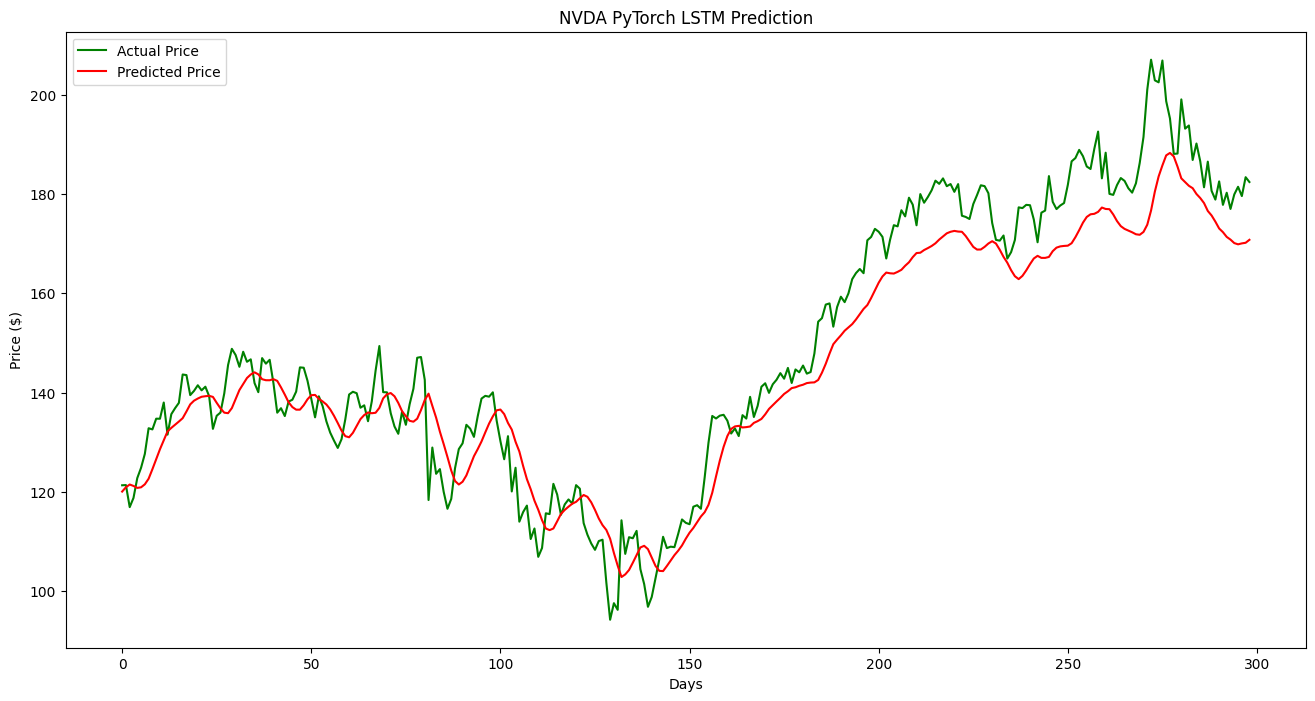

In [19]:
# Plotting
plt.figure(figsize=(16,8))
plt.title(f'{STOCK_SYMBOL} PyTorch LSTM Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.plot(actuals_real, color='green', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.legend()
plt.show()

In [20]:
rmse = np.sqrt(np.mean(((predictions - actuals_real) ** 2)))
print(f"RMSE: {rmse:.2f}")

RMSE: 8.41
